<a href="https://colab.research.google.com/gist/maya2d26/d168b6f0e4966e88afb697623576c4d0/facerecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Python és LUA alapokon -  Homework - II. Milestone**


---

**Group name : * *Rise of AI* ***

Group Members: Tugyi Beatrix (T63K63), El-Ali Maya (BHI5LF), Simkó Máté (O3BMRX)

**Chosen task: Face Recognition and Generation**

**Dataset: [FairFace Datset](https://github.com/joojs/fairface)**

#Imports

In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

import dlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from PIL import Image
import torch.nn.functional as F

from torchmetrics import Accuracy
from torchmetrics.classification import MultilabelAccuracy

from tqdm.notebook import tqdm #a progress bar for aesthetic training visualisation
import torchvision.models as models #for the models used in transfer learning

#Loading the data

In [3]:
# getting the images
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86" -O data.zip && rm -rf /tmp/cookies.txt

--2022-11-20 16:07:02--  https://docs.google.com/uc?export=download&confirm=t&id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
Resolving docs.google.com (docs.google.com)... 108.177.119.139, 108.177.119.138, 108.177.119.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mi5ob84b7q7joqh6r6ove5lksmnc0co7/1668960375000/03161587497725415728/*/1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86?e=download&uuid=a53a8569-c14d-4626-be7e-6813eb79d264 [following]
--2022-11-20 16:07:02--  https://doc-0g-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mi5ob84b7q7joqh6r6ove5lksmnc0co7/1668960375000/03161587497725415728/*/1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86?e=download&uuid=a53a8569-c14d-4626-be7e-6813eb79d264
Resolving doc-0g-64-docs.googleusercontent.com (doc-0g-64-docs.googleusercontent.com)... 74.125.128.1

In [4]:
# getting the training labels
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH' -O "fairface_label_train.csv"

--2022-11-20 16:07:05--  https://docs.google.com/uc?export=download&id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH
Resolving docs.google.com (docs.google.com)... 108.177.119.139, 108.177.119.138, 108.177.119.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v4oguff9i1sbjh4jjb8td9prf42nptr8/1668960375000/03161587497725415728/*/1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH?e=download&uuid=7a6d94cb-55f9-41f2-87ae-9aa796518902 [following]
--2022-11-20 16:07:06--  https://doc-04-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v4oguff9i1sbjh4jjb8td9prf42nptr8/1668960375000/03161587497725415728/*/1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH?e=download&uuid=7a6d94cb-55f9-41f2-87ae-9aa796518902
Resolving doc-04-64-docs.googleusercontent.com (doc-04-64-docs.googleusercontent.com)... 74.125.128.132, 2a00:1

In [5]:
# getting the validation labels
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D' -O "fairface_label_val.csv"

--2022-11-20 16:07:07--  https://docs.google.com/uc?export=download&id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D
Resolving docs.google.com (docs.google.com)... 108.177.119.139, 108.177.119.138, 108.177.119.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m29k808smd9enci1qp6bhts8bvsiti6p/1668960375000/03161587497725415728/*/1wOdja-ezstMEp81tX1a-EYkFebev4h7D?e=download&uuid=b70bd056-0d34-48b8-9489-8e8d1ed2a38b [following]
--2022-11-20 16:07:08--  https://doc-08-64-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m29k808smd9enci1qp6bhts8bvsiti6p/1668960375000/03161587497725415728/*/1wOdja-ezstMEp81tX1a-EYkFebev4h7D?e=download&uuid=b70bd056-0d34-48b8-9489-8e8d1ed2a38b
Resolving doc-08-64-docs.googleusercontent.com (doc-08-64-docs.googleusercontent.com)... 74.125.128.132, 2a00:1

In [6]:
#unzip the images
! unzip  *data.zip

Archive:  data.zip
replace train/1346.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
#number of training images
! ls train | wc -l

86744


In [8]:
#number of validation images
! ls val | wc -l

10954


#Prepprocessing the data

In [27]:
#for encoding multiclass labels
def one_hot_df(df,target):

  label = df[target]
  label= pd.get_dummies(label)

  return pd.concat([label], axis=1)

#for encoding binary labels
def to_categorical(df,target):

  df[target] = df[target].astype('category')
  df[target] = df[target].cat.codes

  return df

#for encoding the given target label
def encode_target(train,valid,test,target):
  if(target == "gender"):
    Y_train = to_categorical(train,target)
    Y_valid = to_categorical(valid,target)
    Y_test = to_categorical(test,target)
  if(target == "multi"):
    print("multi")
  if(target == "race" or target == "age"):
    Y_train = one_hot_df(train,target)
    Y_valid = one_hot_df(valid,target)
    Y_test = one_hot_df(test,target)
  return Y_train, Y_valid, Y_test

In [28]:
def preprocess(target="multi"):
  #loading the labels
  train_df = pd.read_csv("fairface_label_train.csv")
  train_df = train_df.drop(['service_test'], axis=1)
  print("Number of all training images: " + str(len(train_df)))
  valid_df = pd.read_csv("fairface_label_val.csv")
  valid_df = valid_df.drop(["service_test"], axis = 1)
  print("Number of validation images: " + str(len(valid_df)))
  #splitting the data
  print("Splitting the data...")
  if(target != "multi"):
    train_x = train_df.loc[:, train_df.columns == "file"]
    train_y = train_df.loc[:, train_df.columns == target]
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify = train_y)
    print("Number of training images: " + str(len(X_train_raw)))
    print("Number of test images: " + str(len(X_test_raw)))
    valid_x = valid_df.loc[:, valid_df.columns == "file"]
    valid_y = valid_df.loc[:, valid_df.columns == target]
  else:
    print("multi")
  #encoding the data
  print("Encoding target labels...")
  Y_train_, Y_valid_, Y_test_ = encode_target(y_train_raw, valid_y, y_test_raw, target)
  #When creating the test dataset using train_test_split, the indeces were also scrambled, so they need to be renumbered
  X_train_ = X_train_raw.reset_index(drop=True)
  Y_train_ = Y_train_.reset_index(drop=True)
  X_test_ = X_test_raw.reset_index(drop=True)
  Y_test_ = Y_test_.reset_index(drop=True)
  #renaming variable
  X_valid_ = valid_x
  print("Preprocessing finished!")

  return X_train_, Y_train_, X_valid_, Y_valid_, X_test_, Y_test_


**You can choose the target label here**

In [29]:
target = "age" #"gender", "age", "race"
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = preprocess(target)

Number of all training images: 86744
Number of validation images: 10954
Splitting the data...
Number of training images: 78069
Number of test images: 8675
Encoding target labels...
Preprocessing finished!


#**Create a DataLoader for the images**

In [30]:
#Defining our own dataset
class FaceRecognitionDataset(Dataset):  
    def __init__(self, image_ds, label_ds, transform=None):
        self.label_ds = label_ds
        self.ds = image_ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img = dlib.load_rgb_image(self.ds["file"][idx])
        img = torchvision.transforms.ToPILImage()(img)
        label = self.label_ds.iloc[idx]
        label = torch.tensor(label)
        if self.transform:
            img = self.transform(img)  
            return img, label

In [31]:
# Trasformation of the Images
# On the train set: We Crop, Flip and Rotate and we transform both the train, test and valid datasets to tensors

train_transform = transforms.Compose([
    transforms.RandomCrop(200, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),  
])

val_and_test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [32]:
#Creating the datasets
train_dataset = FaceRecognitionDataset(X_train, Y_train, train_transform) 
val_dataset = FaceRecognitionDataset(X_valid, Y_valid, val_and_test_transform)
test_dataset = FaceRecognitionDataset(X_test, Y_test, val_and_test_transform)

In [33]:
#Create the dataloaders
batch_size = 32
num_workers = 2
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size, num_workers=num_workers, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

#Set GPU usage

In [34]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    torch.device('cpu')
#CUDA check
device = get_default_device()
device

device(type='cuda')

In [35]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl 
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [36]:
#Creating the dataloaders on the used device
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

#Model

In [37]:
#custom accuracy
def accuracy(preds, labels): 
    if(preds.shape[1]!=1): 
      _, preds = torch.max(preds, dim=1)
      _, labels = torch.max(labels, dim=1)
  
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [78]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        targets = targets.type(torch.float32)

        loss_fn = nn.CrossEntropyLoss() 
        loss = loss_fn(out, targets)  #multi_target_loss(out, targets) 
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        targets = targets.type(torch.float32)
        out = self(img)
        loss_fn = nn.CrossEntropyLoss()    
        loss = loss_fn(out, targets)  #multi_target_loss(out, targets) 
        targets = targets.type(torch.int32)
        #accuracy = Accuracy(num_classes=out.shape[1]).to(device) 
        acc = accuracy(out, targets)
        return {'val_acc':acc,  'val_loss':loss}
    
    # validation step at the end of the epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
       
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}


    # Printing the results at the end of the epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}"
        .format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))

In [79]:
# Defining the model
class FaceClassificationResnet34(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()       
        self.network = models.resnet34(pretrained=True)
        if (num_classes == 1):
           self.activation = nn.Sigmoid()
        else:
          self.activation = nn.Softmax(1)

        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs,256),
            nn.Linear(256,128),
            nn.Linear(128,64),
            nn.Linear(64,num_classes),  # for the n output
            self.activation
        )
        
    def forward(self, xb):
        return self.network(xb)

In [145]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay, grad_clip, opt_func):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # setting the learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in range(epochs):      
        # Training
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)       
            # Gradient backpropogation
            loss.backward()            
            # Gradient clipping if needed
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)              
            # Performing gradient descent -> recalculating weights
            optimizer.step()           
            # Reset gradients
            optimizer.zero_grad()         
            # Save, update learning rate
            lrs.append(get_lr(optimizer))          
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
             
    return history

# For evaluating the test and the validation datasets -> no gradient calculation
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

@torch.no_grad()
def predict(model, test_loader):
  preds = [model(img) for img, targets in test_loader]
  preds = [pred.cpu().detach().numpy() for pred in preds]
  preds = [np.argmax(pred, axis=1) for pred in preds]
  preds = [item for sublist in preds for item in sublist] 
  return preds


In [81]:
#initialise model
num_classes = Y_train.shape[1]
ResnetModel = FaceClassificationResnet34(num_classes)
print(ResnetModel)
to_device(ResnetModel, device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaceClassificationResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

FaceClassificationResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

#Training

In [43]:
#set hiperparameters
num_epochs = 3
opt_func = torch.optim.Adam
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4

In [44]:
history_RN = fit_one_cycle(num_epochs, max_lr, ResnetModel, train_dl, val_dl, 
                           weight_decay, grad_clip, opt_func)

  0%|          | 0/2440 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [0] : train_loss: 2.0421, val_loss: 2.0622, val_acc: 0.3013


  0%|          | 0/2440 [00:00<?, ?it/s]

Epoch [1] : train_loss: 2.0644, val_loss: 2.0627, val_acc: 0.3013


  0%|          | 0/2440 [00:00<?, ?it/s]

Epoch [2] : train_loss: 2.0630, val_loss: 2.0583, val_acc: 0.3013


#Visualize History

In [45]:
import matplotlib.pyplot as plt
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history_RN)))
for h in history_RN:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

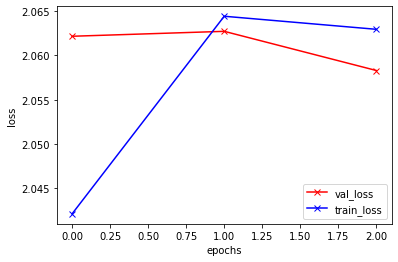

In [47]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

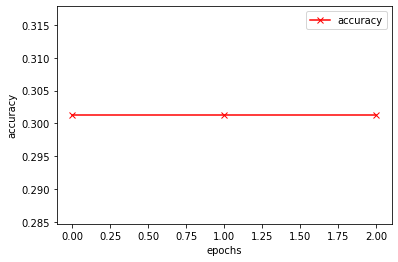

In [48]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#Save the model

In [50]:
import datetime

torch.save(ResnetModel, 'ResnetModel_'+target+'_'+str(datetime.datetime.now())+'.pth')

#Evaluation

In [155]:
#load the model if needed
saved = torch.load('ResnetModel_race.pth')

In [162]:
result = evaluate(saved, test_dl)
print("Test loss: " ,result['val_loss'])
print("Test accuracy: ",result['val_acc'])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test loss:  2.061224937438965
Test accuracy:  0.2952282428741455


In [163]:
preds = predict(saved, test_dl)

In [164]:
labels = [targets for img,targets in test_dl]
labels = [label.cpu().detach().numpy() for label in labels]
labels = [np.argmax(label, axis=1) for label in labels]
labels = [item for sublist in labels for item in sublist] 

In [165]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.00      0.00      0.00       910
           2       0.30      1.00      0.46      2560
           3       0.00      0.00      0.00      1041
           4       0.00      0.00      0.00      1925
           5       0.00      0.00      0.00      1075
           6       0.00      0.00      0.00       623
           7       0.00      0.00      0.00       278
           8       0.00      0.00      0.00        84

    accuracy                           0.30      8675
   macro avg       0.03      0.11      0.05      8675
weighted avg       0.09      0.30      0.13      8675



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [166]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(labels, preds)
print(cf_matrix)

[[   0    0  179    0    0    0    0    0    0]
 [   0    0  910    0    0    0    0    0    0]
 [   0    0 2560    0    0    0    0    0    0]
 [   0    0 1041    0    0    0    0    0    0]
 [   0    0 1925    0    0    0    0    0    0]
 [   0    0 1075    0    0    0    0    0    0]
 [   0    0  623    0    0    0    0    0    0]
 [   0    0  278    0    0    0    0    0    0]
 [   0    0   84    0    0    0    0    0    0]]


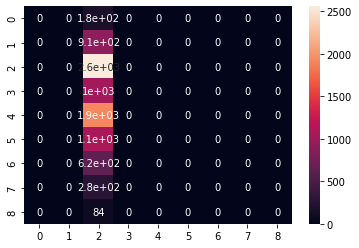

In [167]:
import seaborn as sns

sns.heatmap(cf_matrix, annot=True)